In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

Using GPU: NVIDIA GeForce RTX 2060 SUPER


In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu118
True


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna
from typing import Tuple, Any, Iterable, Dict

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Double Pendulum Dynamics
def double_pendulum(t, y, l1, l2, m1, m2, g):
    theta1, z1, theta2, z2 = y
    delta = theta2 - theta1
    denom1 = (m1 + m2) * l1 - m2 * l1 * np.cos(delta) ** 2
    denom2 = (l2 / l1) * denom1

    dydt = np.zeros_like(y)
    dydt[0] = z1
    dydt[1] = (
        (m2 * l1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
         + m2 * g * np.sin(theta2) * np.cos(delta)
         + m2 * l2 * z2 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta1))
        / denom1
    )
    dydt[2] = z2
    dydt[3] = (
        (-m2 * l2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
         + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
         - (m1 + m2) * l1 * z1 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta2))
        / denom2
    )
    return dydt

In [8]:
#define the datasets size and dt
n_pendulums = 20
dt = 0.01

In [9]:
# Dataset Generation
def generate_dataset(n_pendulums, dt):
    X_data, y_data = [], []
    for _ in range(n_pendulums):
        l1, l2 = np.random.uniform(0.5, 2.0, 2)
        m1, m2 = np.random.uniform(0.5, 2.0, 2)
        g = 9.81
        y0 = np.random.uniform(-np.pi, np.pi, 4)
        t_span = (0, 10)
        t_eval = np.linspace(t_span[0], t_span[1], int(10 / dt))

        sol = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval, args=(l1, l2, m1, m2, g), method='RK45')
        theta1, z1, theta2, z2 = sol.y

        for i in range(len(t_eval) - 1):
            current_state = [theta1[i], theta2[i], z1[i], z2[i]]
            next_state = [theta1[i + 1], theta2[i + 1], z1[i + 1], z2[i + 1]]
            X_data.append(current_state)
            y_data.append(next_state)

    X_data = torch.tensor(X_data, dtype=torch.float32)
    y_data = torch.tensor(y_data, dtype=torch.float32)
    return X_data, y_data

In [10]:
X_data, y_data = generate_dataset(n_pendulums, dt)

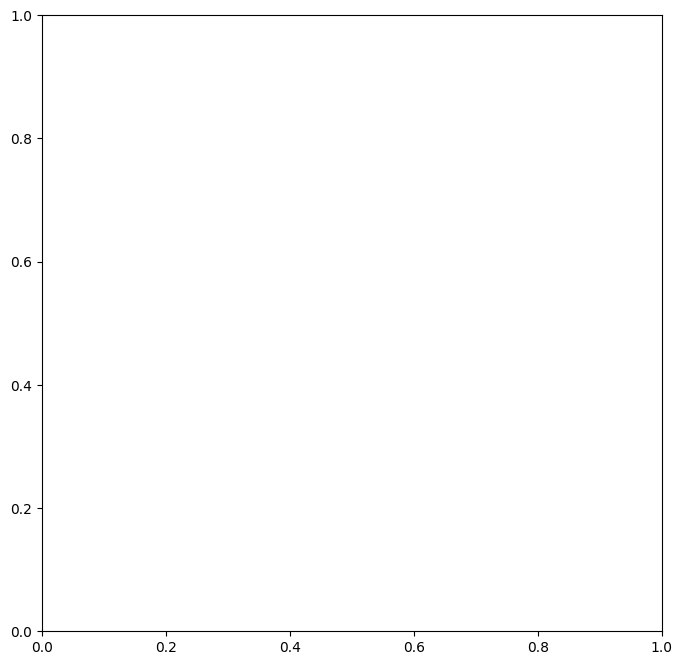

In [11]:
# Animation function
def animate(i):
    ax.clear()
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')

    # Draw pendulums
    for n in range(n_pendulums):
        theta1, omega1, theta2, omega2 = X_data[n*500 + i]  # Extract frames every dt seconds
        x1 = l1 * np.sin(theta1)
        y1 = -l1 * np.cos(theta1)
        x2 = x1 + l2 * np.sin(theta2)
        y2 = y1 - l2 * np.cos(theta2)
        ax.plot([0, x1, x2], [0, y1, y2], 'o-', lw=2, markersize=8)
        ax.set_title(f"Time: {i*dt:.2f}s")

fig, ax = plt.subplots(figsize=(8, 8))
ani = FuncAnimation(fig, animate, frames=500, interval=20, repeat=True)
plt.show()

In [12]:
# Split the dataset
train_size = int(0.7 * len(X_data))
val_size = int(0.2 * len(X_data))
test_size = len(X_data) - train_size - val_size

train_X, train_y = X_data[:train_size], y_data[:train_size]
val_X, val_y = X_data[train_size:train_size + val_size], y_data[train_size:train_size + val_size]
test_X, test_y = X_data[train_size + val_size:], y_data[train_size + val_size:]

# Convert to TensorDataset
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


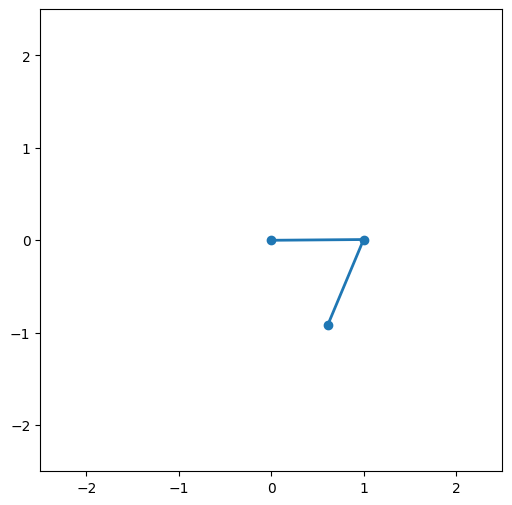

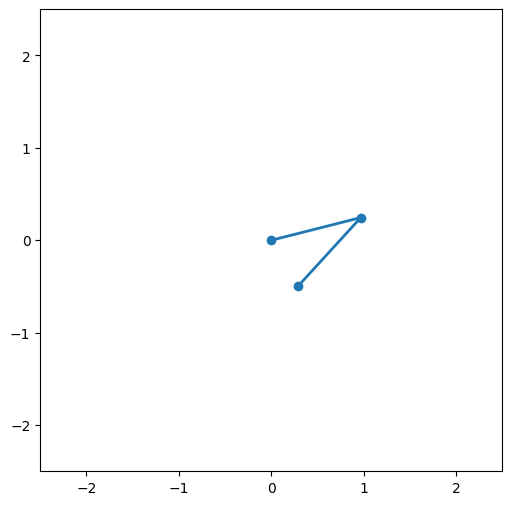

In [13]:
# Visualization of Double Pendulum as Animation
def visualize_double_pendulum(X_data, l1=1.0, l2=1.0, save_path=None):
    theta1 = X_data[:, 0].numpy()
    theta2 = X_data[:, 1].numpy()

    # Compute positions
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta2)
    y2 = y1 - l2 * np.cos(theta2)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        line.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
        return line,

    ani = FuncAnimation(fig, update, frames=len(theta1), blit=True, interval=50)

    if save_path:
        ani.save(save_path, fps=20, writer='imagemagick')
    else:
        plt.show()

# Example Visualization
# Visualize two examples
visualize_double_pendulum(X_data[:200], save_path='double_pendulum1.gif')  # Example from the dataset
visualize_double_pendulum(X_data[200:400], save_path='double_pendulum2.gif')

In [14]:
# Energy-Based Loss Function
def energy_loss(pred_coords, pred_coords_dot, true_coords, true_coords_dot, l1, l2, m1, m2, g):
    def compute_energy(coords, coords_dot):
        theta1, theta2 = coords[:, 0], coords[:, 1]
        theta1_dot, theta2_dot = coords_dot[:, 0], coords_dot[:, 1]

        T1 = 0.5 * m1 * (l1 ** 2) * (theta1_dot ** 2)
        T2 = 0.5 * m2 * (
            (l1 ** 2) * (theta1_dot ** 2)
            + (l2 ** 2) * (theta2_dot ** 2)
            + 2 * l1 * l2 * theta1_dot * theta2_dot * torch.cos(theta2 - theta1)
        )
        V1 = -m1 * g * l1 * torch.cos(theta1)
        V2 = -m2 * g * (l1 * torch.cos(theta1) + l2 * torch.cos(theta2))

        T = T1 + T2
        V = V1 + V2
        return T + V

    pred_energy = compute_energy(pred_coords, pred_coords_dot)
    true_energy = compute_energy(true_coords, true_coords_dot)

    return torch.mean((pred_energy - true_energy) ** 2)

In [15]:
# Double Pendulum LNN Class
class LagrangianNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LagrangianNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)  # Output the Lagrangian scalar
        )

    def forward(self, x):
        return self.net(x)

In [16]:
class DoublePendulumLNN:
    def __init__(self, hidden_dim=128, lr=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LagrangianNN(input_dim=4, hidden_dim=hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        self.criterion = nn.MSELoss()

In [17]:
def predict_next_state(self, coords, coords_dot, dt):
    coords.requires_grad_(True)
    coords_dot.requires_grad_(True)

    coords_dot_input = torch.cat((coords, coords_dot), dim=1)
    print(f"coords.requires_grad: {coords.requires_grad}, coords_dot.requires_grad: {coords_dot.requires_grad}")
    print(f"coords_dot_input.requires_grad: {coords_dot_input.requires_grad}")

    L = self.model(coords_dot_input)
    print(f"L.requires_grad: {L.requires_grad}, L.grad_fn: {L.grad_fn}")

    accel = self.lagrangian_to_accelerations(coords, coords_dot, L)

    k1 = accel
    k2 = accel + 0.5 * dt * k1
    k3 = accel + 0.5 * dt * k2
    k4 = accel + dt * k3

    next_coords = coords + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    next_coords_dot = coords_dot + accel * dt
    return next_coords, next_coords_dot
    pass

In [18]:
def lagrangian_to_accelerations(self, coords, coords_dot, L):
    coords.requires_grad_(True)
    coords_dot.requires_grad_(True)

    print(f"Checking gradients for coords and coords_dot...")
    print(f"L: {L}")
    print(f"coords.requires_grad: {coords.requires_grad}, coords_dot.requires_grad: {coords_dot.requires_grad}")
    print(f"L.requires_grad: {L.requires_grad}")

    dL_dq = torch.autograd.grad(L.sum(), coords, create_graph=True, allow_unused=True)[0]
    dL_dq_dot = torch.autograd.grad(L.sum(), coords_dot, create_graph=True, allow_unused=True)[0]

    if dL_dq is None or dL_dq_dot is None:
        print("Gradient calculation failed. L is not properly connected to coords or coords_dot.")
        print(f"L: {L}")
        print(f"dL_dq: {dL_dq}, dL_dq_dot: {dL_dq_dot}")
        raise ValueError("Gradient calculation returned None. Check inputs and computation graph.")

    accel = torch.autograd.grad(dL_dq_dot.sum(), coords_dot, create_graph=True, allow_unused=True)[0] - dL_dq
    return accel
    pass

In [19]:
def train(self, train_loader, val_loader, dt, epochs=100, l1=1.0, l2=1.0, m1=1.0, m2=1.0, g=9.81):
    scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.5)
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(epochs):
        self.model.train()
        total_loss = 0
        for coords, true_next_coords in train_loader:
            coords, true_next_coords = coords.to(self.device), true_next_coords.to(self.device)
            coords, coords_dot = coords[:, :2], coords[:, 2:]
            true_coords, true_coords_dot = true_next_coords[:, :2], true_next_coords[:, 2:]

            self.optimizer.zero_grad()
            pred_next_coords, pred_next_coords_dot = self.predict_next_state(coords, coords_dot, dt)

            loss = (
                self.criterion(pred_next_coords, true_coords)
                + self.criterion(pred_next_coords_dot, true_coords_dot)
                + energy_loss(pred_next_coords, pred_next_coords_dot, true_coords, true_coords_dot, l1, l2, m1, m2, g)
            )
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        val_loss = self.evaluate(val_loader, dt, l1, l2, m1, m2, g)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss / len(train_loader):.6f}, Val Loss: {val_loss:.6f}")

        if early_stopping(val_loss):
            print("Early stopping triggered.")
            break
        pass

In [20]:
def evaluate(self, data_loader, dt, l1=1.0, l2=1.0, m1=1.0, m2=1.0, g=9.81):
    self.model.eval()
    total_loss = 0
    with torch.no_grad():
        for coords, true_next_coords in data_loader:
            coords, true_next_coords = coords.to(self.device), true_next_coords.to(self.device)
            coords, coords_dot = coords[:, :2], coords[:, 2:]
            true_coords, true_coords_dot = true_next_coords[:, :2], true_next_coords[:, 2:]

            pred_next_coords, pred_next_coords_dot = self.predict_next_state(coords, coords_dot, dt)

            loss = (
                self.criterion(pred_next_coords, true_coords)
                + self.criterion(pred_next_coords_dot, true_coords_dot)
                + energy_loss(pred_next_coords, pred_next_coords_dot, true_coords, true_coords_dot, l1, l2, m1, m2, g)
            )
            total_loss += loss.item()

    return total_loss / len(data_loader)
    pass    

In [21]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [26]:
# Train Best Model
lnn = DoublePendulumLNN(input_dim=4, hidden_dim = 128)
lnn.train(train_loader, val_loader, dt, epochs=100)

TypeError: DoublePendulumLNN.__init__() got an unexpected keyword argument 'input_dim'

In [ ]:
# Evaluate on Test Data
test_loss = lnn.evaluate(test_loader, dt)
print(f"Test Loss: {test_loss:.6f}")

In [ ]:
def visualize_predictions_as_video(self, data_loader, dt, l1=1.0, l2=1.0):
    self.model.eval()
    with torch.no_grad():
        for coords, true_next_coords in data_loader:
            coords, coords_dot = coords[:, :2], coords[:, 2:]
            true_coords, true_coords_dot = true_next_coords[:, :2], true_next_coords[:, 2:]

            pred_next_coords, pred_next_coords_dot = self.predict_next_state(coords, coords_dot, dt)

            # Visualize the first example in the batch
            theta1 = coords[0, 0].item()
            theta2 = coords[0, 1].item()
            theta1_pred = pred_next_coords[0, 0].item()
            theta2_pred = pred_next_coords[0, 1].item()

            # Convert angles to coordinates
            x1_true = l1 * np.sin(theta1)
            y1_true = -l1 * np.cos(theta1)
            x2_true = x1_true + l2 * np.sin(theta2)
            y2_true = y1_true - l2 * np.cos(theta2)

            x1_pred = l1 * np.sin(theta1_pred)
            y1_pred = -l1 * np.cos(theta1_pred)
            x2_pred = x1_pred + l2 * np.sin(theta2_pred)
            y2_pred = y1_pred - l2 * np.cos(theta2_pred)

            fig, ax = plt.subplots()
            ax.set_xlim(-2 * (l1 + l2), 2 * (l1 + l2))
            ax.set_ylim(-2 * (l1 + l2), 2 * (l1 + l2))

            line_true, = ax.plot([], [], 'o-', label='True')
            line_pred, = ax.plot([], [], 'x--', label='Predicted')
            ax.legend()

            def init():
                line_true.set_data([], [])
                line_pred.set_data([], [])
                return line_true, line_pred

            def update(frame):
                nonlocal theta1, theta2, theta1_pred, theta2_pred

                # Update true positions
                theta1 += coords_dot[0, 0].item() * dt
                theta2 += coords_dot[0, 1].item() * dt

                x1_true = l1 * np.sin(theta1)
                y1_true = -l1 * np.cos(theta1)
                x2_true = x1_true + l2 * np.sin(theta2)
                y2_true = y1_true - l2 * np.cos(theta2)

                # Update predicted positions
                theta1_pred += pred_next_coords_dot[0, 0].item() * dt
                theta2_pred += pred_next_coords_dot[0, 1].item() * dt

                x1_pred = l1 * np.sin(theta1_pred)
                y1_pred = -l1 * np.cos(theta1_pred)
                x2_pred = x1_pred + l2 * np.sin(theta2_pred)
                y2_pred = y1_pred - l2 * np.cos(theta2_pred)

                line_true.set_data([0, x1_true, x2_true], [0, y1_true, y2_true])
                line_pred.set_data([0, x1_pred, x2_pred], [0, y1_pred, y2_pred])
                return line_true, line_pred

            ani = FuncAnimation(fig, update, frames=200, init_func=init, blit=True)
            plt.show()
            break